# Switching Recurrent Neural Networks (SRNNs) Tutorial on Lorenz Attractor

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import os
from SRNN import model_srnn
from SRNN import inference_network
from SRNN import initialization
from SRNN import train
from SRNN import generative_check
from sklearn.metrics import mean_squared_error

np.random.seed(131)
torch.manual_seed(131)

#### If you would like to test SRNNs with your own data, please change the 'y_c' in Step 2, 'num_tv' and 'hidden_shape' in Step 3. The visualization depends on your data, so you may delete the visualization of the dataset to run this notebook. Please note that other hyper parameters may also need to change to get good results.

### Step 2: Data load
In this step, we load and visualize the data of lorenz attractor. You may change this 'y_c' to your own data, the data has to be in size of

__(#samples*#time points*#features)__.

In [2]:
import json
import numpy as np
from sklearn.preprocessing import MinMaxScaler

file_paths = [
    '/Users/davydeng/MIT Dropbox/Davy Deng/HST/Boyden/RNN/2022-08-02-01.json',
    '/Users/davydeng/MIT Dropbox/Davy Deng/HST/Boyden/RNN/2023-01-23-15.json',
    '/Users/davydeng/MIT Dropbox/Davy Deng/HST/Boyden/RNN/2023-01-16-15.json',
    '/Users/davydeng/MIT Dropbox/Davy Deng/HST/Boyden/RNN/2022-06-14-07.json',
    '/Users/davydeng/MIT Dropbox/Davy Deng/HST/Boyden/RNN/2022-12-21-06.json'
]

all_scaled_behaviors = []
time_points = 1600

for file_path in file_paths:
    with open(file_path, 'r') as file:
        data = json.load(file)

    behavior = np.vstack((
        np.array(data["angular_velocity"]),
        np.array(data["head_curvature"]),
        np.array(data["velocity"]),
        np.array(data["body_curvature"]),
        np.array(data["pumping"])
    ))

    behavior = behavior[:,:time_points]
    
    scaler_minmax = MinMaxScaler(feature_range=(-1, 1))
    scaled_behavior = scaler_minmax.fit_transform(np.transpose(behavior))
    all_scaled_behaviors.append(scaled_behavior)

all_scaled_behaviors = np.stack(all_scaled_behaviors, axis=0)


In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

X = all_scaled_behaviors[2,:,:]
clusters_range = range(1, 10)
silhouette_values = []

# Evaluate different number of clusters
for n_clusters in clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=99)
    kmeans.fit(X)
        
    # Silhouette score
    if n_clusters > 1:  # Silhouette score requires at least 2 clusters
        silhouette_values.append(silhouette_score(X, kmeans.labels_))
    else:
        silhouette_values.append(-1)  # Silhouette score is undefined for 1 cluster


# Plot Silhouette Score
plt.subplot(122)
plt.plot(clusters_range[1:], silhouette_values[1:], label='Silhouette Score', marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for K-means')
plt.tight_layout()
plt.show()

optimal_clusters_silhouette = clusters_range[1:][np.argmax(silhouette_values[1:])]

print("Optimal number of clusters based on Silhouette Score:", optimal_clusters_silhouette)


In [ ]:
plt.plot(kmeans.labels_)

/Users/davydeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


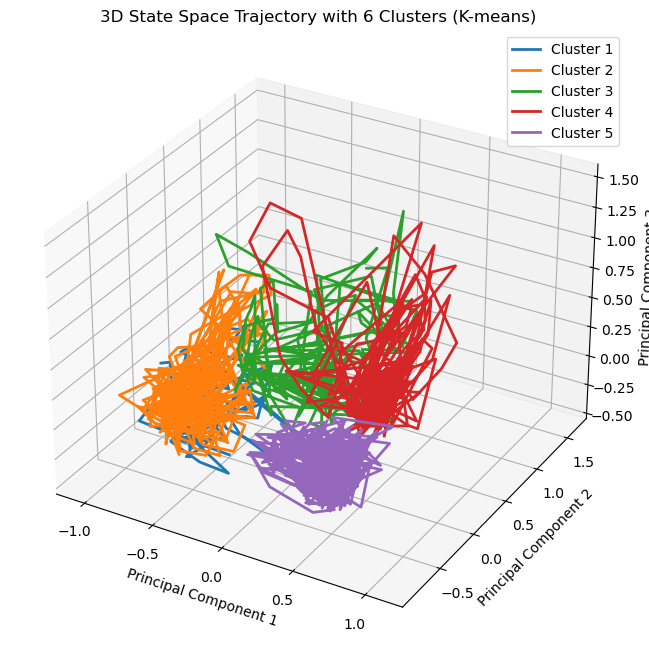

In [11]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D


X = all_scaled_behaviors[2,:,:]

# Apply K-means
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X)

labels = kmeans.labels_

pca = PCA(n_components=3)
X_pca_3d = pca.fit_transform(X)

# Create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the trajectory in 3D, connecting the points with a line and coloring by cluster
for i in range(n_clusters):
    cluster_indices = np.where(labels == i)[0]
    sorted_indices = np.sort(cluster_indices)
    # Plot the trajectory with a line connecting the points, colored by cluster
    ax.plot(X_pca_3d[sorted_indices, 0], X_pca_3d[sorted_indices, 1], X_pca_3d[sorted_indices, 2], 
            label=f'Cluster {i + 1}', linewidth=2)

ax.set_title('3D State Space Trajectory with 6 Clusters (K-means)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

ax.legend(loc='best')

plt.show()


In [3]:
import json
import numpy as np
import pandas as pd
from collections import Counter

def normalize_activity(activity_labelled):
    F0 = np.mean(activity_labelled, axis=0)
    delta_F_over_F0 = (activity_labelled - F0) / F0
    percentile_20 = np.percentile(delta_F_over_F0, 20, axis=0)
    F_scaled = np.maximum(delta_F_over_F0 - percentile_20, 0)
    max_value = np.max(F_scaled)
    return F_scaled / max_value if max_value > 0 else F_scaled




file_paths = [
    '/Users/davydeng/MIT Dropbox/Davy Deng/HST/Boyden/RNN/2022-08-02-01.json',
    '/Users/davydeng/MIT Dropbox/Davy Deng/HST/Boyden/RNN/2023-01-23-15.json',
    '/Users/davydeng/MIT Dropbox/Davy Deng/HST/Boyden/RNN/2023-01-16-15.json',
    '/Users/davydeng/MIT Dropbox/Davy Deng/HST/Boyden/RNN/2022-06-14-07.json',
    '/Users/davydeng/MIT Dropbox/Davy Deng/HST/Boyden/RNN/2022-12-21-06.json'
]



common_neurons = None  
processed_data = []  # To store filtered dataframes and activities

for file_path in file_paths:
    with open(file_path, 'r') as file:
        data = json.load(file)
    
    df = pd.DataFrame.from_dict(data["labeled"], orient='index')
    result_df = df[['label']]
    result_df.reset_index(inplace=True)
    result_df.columns = ['Key', 'Label']
    
    filtered_df = result_df[~result_df['Label'].str.contains('\?', na=False)]
    
    neuron_set = set(filtered_df['Label'].tolist())
    if common_neurons is None:
        common_neurons = neuron_set
    else:
        common_neurons = common_neurons.intersection(neuron_set)
    
    # Extract activity for identified neurons
    activity_labelled = np.array(data['trace_original'])
    processed_data.append((filtered_df, activity_labelled))

# Convert the set of common neurons to a sorted list
ordered_neurons = sorted(common_neurons)

time_points = 1600
ordered_activities_truncated = []

for filtered_df, activity_labelled in processed_data:
    # Create a mapping of neuron labels to their activity indices
    neuron_to_index = {label: int(key) - 1 for key, label in zip(filtered_df['Key'], filtered_df['Label'])}
    
    # Truncate the activity array to the first 1600 time points
    truncated_activity_labelled = normalize_activity(activity_labelled[:time_points, :])
    
    ordered_activity = [truncated_activity_labelled[:, neuron_to_index[neuron]]
                        for neuron in ordered_neurons]
        
    ordered_activities_truncated.append(np.array(ordered_activity).T)



In [4]:
y_c = np.stack(ordered_activities_truncated, axis=0)[2:3,:,:].reshape(8,200,-1)

In [5]:
y_c.shape

(8, 200, 42)

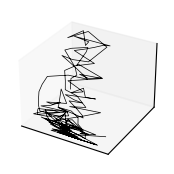

In [6]:
# Let's visualize one trial of lorenz attractors.
ax = plt.figure(figsize=(2,2)).add_subplot(projection='3d')
ax.plot(y_c[0,:,0],y_c[0,:,1], y_c[0,:,2], lw=0.5,color='black')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.show()

We then split the data into training and testing, i.e., 17 trials in training and 1 trials in testing. 'jobid' is to set which trial in testing.

In [7]:
beh_all = all_scaled_behaviors[2:3,:,:].reshape(8,200,-1)

In [8]:
jobid=0 # set first trial to be validation, the rest of trials to be training.
train_data=np.delete(y_c,(int(jobid)),axis=0)
test_data=y_c[int(jobid):int(jobid)+1]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32
X_train=torch.tensor(np.delete(beh_all,(int(jobid)),axis=0),dtype=dtype,device=device)
y_train=torch.tensor(train_data,dtype=dtype,device=device)
y_test=torch.tensor(test_data,dtype=dtype,device=device)
X_test=torch.tensor(beh_all[int(jobid):int(jobid)+1],dtype=dtype,device=device)
### beh_all_train and beh_all_test are behavioral labels, we don't have to use them in lorenz attractor.
beh_all_train=None
beh_all_test=None

In [9]:
y_train.shape

torch.Size([7, 200, 42])

### Step 3: Hyperparameters

In [10]:
input_shape=X_train.shape[2] # Input shape of SRNNs, but the models are input free.
num_tv=5 # Number of RNNs in SRNNs.
hidden_shape=42 # Number of hidden states of SRNNs.
ini_epochs=3000 # Epochs in initialization stage, can be longer than training stage.
coef_cross=0.8 # Coefficient of initialization, larger coef_cross means larger constraint on posterior states in initialization. 
epochs=2000 # Epochs in training stage.
lr=0.001 # Learning rate

### Step 4: Define SRNN and Inference Networks

In [11]:
model = model_srnn.Model(input_shape,num_tv,hidden_shape).to(device)
rnninfer=inference_network.RNNInfer(input_shape,hidden_shape).to(device)

In [12]:
print(model);print(rnninfer)

Model(
  (rnns): ModuleList(
    (0-4): 5 x RNN(5, 42, batch_first=True)
  )
  (emission): Emission(
    (fc1): Linear(in_features=42, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=42, bias=True)
    (relu): ReLU()
  )
  (transitions): RNNCell(42, 25)
)
RNNInfer(
  (forward_rnn): RNN(5, 42, batch_first=True)
  (backward_rnn): RNN(5, 42, batch_first=True)
  (rnn_mean): RNN(42, 42, batch_first=True)
  (lc1): Linear(in_features=84, out_features=64, bias=True)
  (lc2): Linear(in_features=64, out_features=42, bias=True)
  (relu): ReLU()
)


### Step 5: Initialization

In [13]:
optimizer = torch.optim.Adam(list(model.parameters())+list(rnninfer.parameters()) ,lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.8)


In [ ]:
model_ini,rnninfer_ini,mse_all_ini,error_all_ini,mse_all_test_ini,error_all_test_ini,loss_all_ini,pos_test_all_ini=initialization.run(model,
                                                                                                                     rnninfer,
                                                                                                                     optimizer,
                                                                                                                     scheduler,
                                                                                                                     X_train,
                                                                                                                     y_train,
                                                                                                                     X_test,
                                                                                                                     y_test,
                                                                                                                     beh_all_train,
                                                                                                                     beh_all_test,
                                                                                                                     num_tv,
                                                                                                                     coef_cross,
                                                                                                                     ini_epochs,
                                                                                                                     device,
                                                                                                                     method='hmm',
                                                                                                                     t_load=None)

Now, we can test the SRNN after initialization.

In [ ]:
y_pred_test_ini,pos_test_ini,sampled_h_test_ini=train.eval_(model_ini,rnninfer_ini,X_test,y_test,device)

In [ ]:
y_pred_test_ini

#### We also include another tutorial using 'random' initailization, SRNNs are also able to identify correct states.

### Step 6: Training

In [ ]:
model_trained,rnninfer_trained,mse_all_train,error_all_train,mse_all_test,error_all_test,loss_all_test,pos_test_all=train.train_(model_ini,
                                                                                                                    rnninfer_ini,
                                                                                                                    optimizer,
                                                                                                                    scheduler,
                                                                                                                    X_train,
                                                                                                                    y_train,
                                                                                                                    X_test,
                                                                                                                    y_test,
                                                                                                                    beh_all_train,
                                                                                                                    beh_all_test,
                                                                                                                    num_tv,
                                                                                                                    epochs,
                                                                                                                    device)

Now, we can test the SRNN after training.

### Step 7: Analysis

In [ ]:
y_pred_test,pos_test,sampled_h_test=train.eval_(model_trained,rnninfer_trained,X_test,y_test,device)

In [ ]:
sampled_h_test

In [ ]:
# Let's visualize.
color_list=['green','orange']
ax = plt.figure(figsize=(3,3)).add_subplot(projection='3d')
for i in range(len(y_pred_test[0])-2):
    ax.plot(y_pred_test[0,i:i+2,0],y_pred_test[0,i:i+2,1],y_pred_test[0,i:i+2,2], lw=0.5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.show()

In [ ]:
# Let's visualize.
color_list=['green','orange']
ax = plt.figure(figsize=(3,3)).add_subplot(projection='3d')
for i in range(len(y_test.cpu().detach().numpy()[0])-2):
    ax.plot(y_test.cpu().detach().numpy()[0,i:i+2,0],y_test.cpu().detach().numpy()[0,i:i+2,1],y_test.cpu().detach().numpy()[0,i:i+2,2], lw=0.5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.show()

Now, check validation loss and MSE of training.

In [ ]:
plt.figure(figsize=(6,2))
plt.subplot(1,2,1)
plot_epoch=range(ini_epochs+epochs)
plt.plot(plot_epoch[:ini_epochs],mse_all_test_ini)
plt.plot(plot_epoch[ini_epochs:],mse_all_test)
plt.ylabel('MSE')
plt.subplot(1,2,2)
plot_epoch=range(ini_epochs+epochs)
plt.plot(plot_epoch[:ini_epochs],loss_all_ini)
plt.plot(plot_epoch[ini_epochs:],loss_all_test)
plt.show()

Now, let's test whether the generative model works and can generate right trajectory using inferred discrete states.

In [ ]:
generative_y_test,generative_h=generative_check.run(model_trained,rnninfer,X_test,y_test,pos_test,device)

In [ ]:
plt.figure(figsize=(5,3))
lines=plt.plot(generative_h,color='blue',label='generative h')
plt.setp(lines[1:],label='_')
lines=plt.plot(sampled_h_test[0],color='red',label='inferred h')
plt.setp(lines[1:],label='_')
plt.legend()
plt.axis('off')
plt.show()

In [ ]:
plt.figure(figsize=(5,3))
lines=plt.plot(y_pred_test[0][:,0:10],color='purple',label='generative y')
plt.setp(lines[1:],label='_')
lines=plt.plot(y_test.cpu().detach().numpy()[0][:,0:10],color='gray',label='true y')
plt.setp(lines[1:],label='_')
plt.legend()
plt.axis('off')
plt.show()

In [ ]:
# Example sequences
y_true = y_test.cpu().detach().numpy()[0]
y_pred = y_pred_test[0]

# Compute SS_res and SS_tot
ss_res = np.sum((y_true - y_pred) ** 2)
ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)

# Compute R^2
r_squared = 1 - (ss_res / ss_tot)
print("R^2 (Goodness of Fit):", r_squared)

Now, let's look at how states identified by SRNNs change across epochs.

In [ ]:
state_all_ini=[]
for i in range(ini_epochs):
    state_all_ini.append(np.argmax(pos_test_all_ini[i,0,:,:],axis=1))
state_all_ini=np.array(state_all_ini)

state_all=[]
for i in range(epochs):
    state_all.append(np.argmax(pos_test_all[i,0,:,:],axis=1))
state_all=np.array(state_all)

state_entire=np.vstack((state_all_ini,state_all))

In [ ]:
state_entire[-1,:]

In [ ]:
fig, ax = plt.subplots(1,1)
l=int(state_entire.shape[0]/100)
state_show=state_entire[0:1]
for i in range(100):
    state_show=np.vstack((state_show,state_entire[i*l+l:i*l+l+1]))
ax.imshow(state_show,extent=[0,state_show.shape[1],state_entire.shape[0]/l,0])
y_label_list = list(np.linspace(0,state_entire.shape[0],5))
ax.set_yticks(list(np.linspace(0,state_show.shape[0],5)))
ax.set_yticklabels(y_label_list)
plt.show()

In [ ]:
state_entire[-1,:].shape